## Random Forest Regressor Model

### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import glob
import os
import numpy as np
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping


### Data

In [2]:

# Load 2023 Data
dfs = {}
folder_path_23 = "/Users/evanellington/Downloads/CS 230/Project Data/2023"
csv_files_23 = glob.glob(os.path.join(folder_path_23, "*.csv"))

for f in csv_files_23:
    key = os.path.splitext(os.path.basename(f))[0]
    dfs[key] = pd.read_csv(f, encoding="ISO-8859-1")

# Load 2024 Data
dfs_24 = {}
folder_path_24 = "/Users/evanellington/Downloads/CS 230/Project Data/2024"
csv_files_24 = glob.glob(os.path.join(folder_path_24, "*.csv"))

for f in csv_files_24:
    key = os.path.splitext(os.path.basename(f))[0]
    dfs_24[key] = pd.read_csv(f, encoding="ISO-8859-1")


### Model

In [3]:

# -----------------------------
# Helper Functions
# -----------------------------
def merge_seasons(df_2023, df_2024, player_col='Player'):
    """Merge 2023 and 2024 stats per player with suffixes."""
    df_2023 = df_2023.add_suffix('_2023')
    df_2024 = df_2024.add_suffix('_2024')
    merged = pd.merge(df_2024, df_2023,
                      left_on=f'{player_col}_2024',
                      right_on=f'{player_col}_2023',
                      how='left')
    merged['player_name'] = merged[f'{player_col}_2024']
    merged['ADP'] = merged['ADP_2024']
    merged.drop([f'{player_col}_2024', f'{player_col}_2023'], axis=1, inplace=True)
    return merged

def clean_numeric(df, target):
    """Convert all columns to numeric and drop rows with NaNs in features or target."""
    # Ensure target is numeric
    df[target] = pd.to_numeric(df[target], errors='coerce')
    
    # Only numeric features
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if target not in numeric_cols:
        numeric_cols.append(target)
    
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Drop rows with NaN in any numeric column
    df = df.dropna(subset=numeric_cols)
    
    # Remove target from features list
    features = numeric_cols.copy()
    features.remove(target)
    
    return df, features

def train_position_model(df, features, target):
    """Train a Random Forest Regressor for a single position."""
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                        test_size=0.2, random_state=42)
    
    rfr = RandomForestRegressor(n_estimators=200, random_state=42)
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R2 Score: {r2:.3f}, RMSE: {rmse:.3f}")
    
    return rfr

def predict_position(df, model, features):
    """Predict fantasy points for 2025."""
    df['predicted_2025_fp'] = model.predict(df[features])
    df['FantasyPoints'] = df['FantasyPoints_2024']
    return df

# -----------------------------
# Train Models Per Position
# -----------------------------
positions = {
    'QB': ('2023_Stats(QBs)', '2024_Stats(QBs)'),
    'RB': ('2023_Stats(RBs)', '2024_Stats(RBs)'),
    'WR': ('2023_Stats(WRs)', '2024_Stats(WRs)'),
    'TE': ('2023_Stats(TEs)', '2024_Stats(TEs)'),
    'K':  ('2023_Stats(Ks)', '2024_Stats(Ks)'),
    'DST':('2023_Stats(DSTs)', '2024_Stats(DSTs)')
}

predicted_dfs = []
position_models = {}

target = 'FantasyPoints_2024'  # make sure this matches your CSV column name

for pos, (df23_key, df24_key) in positions.items():
    df_2023 = dfs[df23_key]
    df_2024 = dfs_24[df24_key]
    
    merged_df = merge_seasons(df_2023, df_2024, player_col='Name')
    
    merged_df, features = clean_numeric(merged_df, target)
    
    print(f"\nTraining {pos} model...")
    model = train_position_model(merged_df, features, target)
    
    merged_df = predict_position(merged_df, model, features)
    
    merged_df['position'] = pos
    predicted_dfs.append(merged_df)
    position_models[pos] = model

# -----------------------------
# Combine All Positions Into Draft Board
# -----------------------------
draft_board = pd.concat(predicted_dfs, ignore_index=True)
draft_board = draft_board.sort_values('predicted_2025_fp', ascending=False)

# Display top 20 players
print("\nTop 20 Predicted Players for 2025 Fantasy Draft:")
print(draft_board[['player_name', 'position', 'predicted_2025_fp']].head(20))



Training QB model...
R2 Score: 0.674, RMSE: 95.317

Training RB model...
R2 Score: 0.916, RMSE: 30.523

Training WR model...
R2 Score: 0.845, RMSE: 30.567

Training TE model...
R2 Score: 0.948, RMSE: 14.603

Training K model...
R2 Score: 0.913, RMSE: 7.927

Training DST model...
R2 Score: 0.762, RMSE: 12.332

Top 20 Predicted Players for 2025 Fantasy Draft:
          player_name position  predicted_2025_fp
3          Josh Allen       QB           391.4480
1          Joe Burrow       QB           384.5995
2      Baker Mayfield       QB           371.9655
0       Lamar Jackson       QB           361.4855
8     Patrick Mahomes       QB           345.2360
75     Saquon Barkley       RB           339.4165
6         Jalen Hurts       QB           330.3675
76     Bijan Robinson       RB           329.4085
77      Derrick Henry       RB           319.5190
151  Justin Jefferson       WR           304.9015
7        Kyler Murray       QB           304.1750
150       Amon-Ra St.       WR         

### Snake Draft

In [9]:
def get_best_available(player_pool, current_roster=None, sort_column='ADP'):
    """
    Returns the best available player based on the given sort_column.
    """
    available = player_pool[player_pool['Drafted'] == False]

    # Sort ascending for ADP, descending for projections
    if sort_column.upper() == 'ADP':
        available = available.sort_values(by='ADP', ascending=True)
    else:
        available = available.sort_values(by=sort_column, ascending=False)

    return available.iloc[0]


def find_column(df, possible_names):
    """
    Searches for a column in the DataFrame matching ANY of the names in possible_names.
    Case-insensitive.
    """
    df_cols = {c.lower(): c for c in df.columns}

    for name in possible_names:
        if name.lower() in df_cols:
            return df_cols[name.lower()]

    return None

# Max limits for roster
ROSTER_LIMITS = {
    'QB': 2,
    'RB': 6,
    'WR': 6,
    'TE': 2,
    'K': 1,
    'DST': 1
}

# Min requirements for roster
MINIMUM_REQUIRED = {
    'QB': 1,
    'RB': 1,
    'WR': 1,
    'TE': 1,
    'K': 1,
    'DST': 1
}

def plot_model_vs_all_opponents_histogram(model_scores, all_opp_scores, model_name="NN"):
    """
    Plot histogram of model team scores and overlay all individual opponent scores,
    plus shaded regions showing their score ranges.
    """

    # Flatten opponent scores
    flattened_opp_scores = [score for sim_scores in all_opp_scores for score in sim_scores]

    # Compute ranges
    model_min, model_max = min(model_scores), max(model_scores)
    opp_min, opp_max     = min(flattened_opp_scores), max(flattened_opp_scores)

    plt.figure(figsize=(12, 7))

    # --- Shaded Range for Model Scores ---
    plt.axvspan(model_min, model_max, color='blue', alpha=0.1, label=f"{model_name} Score Range")

    # --- Shaded Range for Opponent Scores ---
    plt.axvspan(opp_min, opp_max, color='orange', alpha=0.1, label="Opponent Score Range")

    # --- Histograms ---
    plt.hist(model_scores, bins=10, alpha=0.6, color='blue', label=f'{model_name} Team Scores')
    plt.hist(flattened_opp_scores, bins=20, alpha=0.6, color='orange', label='All Opponent Scores')

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Total Fantasy Points", fontsize = 18)
    plt.ylabel("Frequency", fontsize = 18)
    plt.legend(loc="upper left", fontsize = 18)
    plt.tight_layout()
    plt.show()

In [10]:
def run_rfr_snake_draft(master_pool, num_simulations=200, num_teams=12, rounds=15):
    """
    Complete snake-draft simulation using Random Forest predictions:
      - Team drafts using RFR predictions ('predicted_2025_fp')
      - Opponents draft using ADP with some randomness
      - Returns average scores across simulations
      - Outputs last simulation teams
    """

    required_cols = ['FantasyPoints', 'predicted_2025_fp', 'ADP', 'position']
    for col in required_cols:
        if col not in master_pool.columns:
            raise KeyError(f"Master pool is missing required column: '{col}'")

    master_pool = master_pool.copy()
    master_pool['FantasyPoints'] = pd.to_numeric(master_pool['FantasyPoints'], errors='coerce').fillna(0)
    master_pool['predicted_2025_fp'] = pd.to_numeric(master_pool['predicted_2025_fp'], errors='coerce').fillna(0)
    master_pool['ADP'] = pd.to_numeric(master_pool['ADP'], errors='coerce').fillna(999.0)

    print("Running Random Forest snake-draft simulations...")

    model_scores = []
    baseline_scores = []
    model_wins = 0
    last_sim_teams = None
    all_opponent_scores = []

    

    for sim in range(num_simulations):
        model_slot = np.random.randint(0, num_teams)
        player_pool = master_pool.copy()
        player_pool['Drafted'] = False
        teams = {i: [] for i in range(num_teams)}

        for round_num in range(rounds):
            order = list(range(num_teams)) if round_num % 2 == 0 else list(reversed(range(num_teams)))

            for team_idx in order:
                roster = teams[team_idx]
                sort_col = 'predicted_2025_fp' if team_idx == model_slot else 'ADP'

                # Count players by position
                # Count players by position
                pos_counts = {pos: sum(p['position'] == pos for p in roster) for pos in ROSTER_LIMITS}

                available_players = player_pool[player_pool['Drafted'] == False].copy()

                # Enforce maximums for all teams
                for pos, max_limit in ROSTER_LIMITS.items():
                    if pos_counts.get(pos, 0) >= max_limit:
                        available_players = available_players[available_players['position'] != pos]

                # Enforce minimums only for last picks of a team
                remaining_picks = rounds - len(roster)
                positions_needed = []
                if remaining_picks <= 2:  # last 2 picks
                    positions_needed = [pos for pos, min_req in MINIMUM_REQUIRED.items()
                        if pos_counts.get(pos, 0) < min_req]
                    if positions_needed:
                        available_players = available_players[available_players['position'].isin(positions_needed)]


                if available_players.empty:
                    continue

                # --- Pick player ---
                TOP_N_OPPONENT = 5  # randomness for opponent picks
                if sort_col == 'ADP':
                    top_n = available_players.sort_values(by='ADP', ascending=True).head(TOP_N_OPPONENT)
                    pick = top_n.sample(n=1).iloc[0]
                else:
                    pick = available_players.sort_values(by='predicted_2025_fp', ascending=False).iloc[0]

                player_pool.loc[pick.name, 'Drafted'] = True
                teams[team_idx].append(pick)

        # Scoring
        model_team_df = pd.DataFrame(teams[model_slot])
        model_score = model_team_df['FantasyPoints'].sum()
        model_scores.append(model_score)

        opp_scores = []
        for opp in range(num_teams):
            if opp != model_slot:
                opp_df = pd.DataFrame(teams[opp])
                opp_scores.append(opp_df['FantasyPoints'].sum())
        all_opponent_scores.append(opp_scores)
        baseline_avg = np.mean(opp_scores)
        baseline_scores.append(baseline_avg)

        if model_score > max(opp_scores):
            model_wins += 1

        # Save last simulation
        if sim == num_simulations - 1:
            last_sim_teams = {k: pd.DataFrame(v) for k, v in teams.items()}

    avg_model = np.mean(model_scores)
    avg_baseline = np.mean(baseline_scores)
    diff = avg_model - avg_baseline

    print("\n==============================")
    print("   FINAL RANDOM FOREST DRAFT RESULTS")
    print("==============================")
    print(f"Avg Model Score:    {avg_model:.2f}")
    print(f"Avg Opponent Score: {avg_baseline:.2f}")
    print(f"Advantage:          {diff:.2f} points")
    print(f"Model Wins:         {model_wins}/{num_simulations} simulations")
    print("==============================")

    # Show last simulation teams
    print("\n=== Last Simulation Drafted Teams ===")
    for team_idx, df in last_sim_teams.items():
        team_label = f"Team {team_idx + 1}"
        if team_idx == model_slot:
            team_label += " (RFR Model's Team)"

        total_fp = df['predicted_2025_fp'].sum() if not df.empty else 0
        print(f"\n{team_label} — Total Projected Fantasy Points: {total_fp:.2f}")

        if not df.empty:
            print(df[['player_name', 'position', 'predicted_2025_fp', 'FantasyPoints', 'ADP']])
        else:
            print("No players drafted")

    return {
        "avg_model": avg_model,
        "avg_baseline": avg_baseline,
        "difference": diff,
        "model_wins": model_wins,
        "last_sim_teams": last_sim_teams,
        "baseline_scores": baseline_scores,
        "model_scores": model_scores,
        "all_opponent_scores": all_opponent_scores
    }


In [17]:
rfr_results = run_rfr_snake_draft(draft_board, num_simulations=100)

Running Random Forest snake-draft simulations...

   FINAL RANDOM FOREST DRAFT RESULTS
Avg Model Score:    3678.08
Avg Opponent Score: 2649.74
Advantage:          1028.34 points
Model Wins:         100/100 simulations

=== Last Simulation Drafted Teams ===

Team 1 — Total Projected Fantasy Points: 2246.80
            player_name position  predicted_2025_fp  FantasyPoints    ADP
163         Tyreek Hill       WR           217.0160          218.2    2.5
128       Isiah Pacheco       RB            63.2820           57.0   24.5
168        Nico Collins       WR           214.9200          210.6   29.0
221        Trey McBride       TE           211.9250          243.8   48.5
187       Jaylen Waddle       WR           159.5440          150.1   38.5
220         Rashee Rice       WR            69.0170           64.9   66.5
26         Dak Prescott       QB           180.1880          138.4   77.0
111        Tyjae Spears       RB           104.1290          113.6  101.5
17       Tua Tagovailoa    

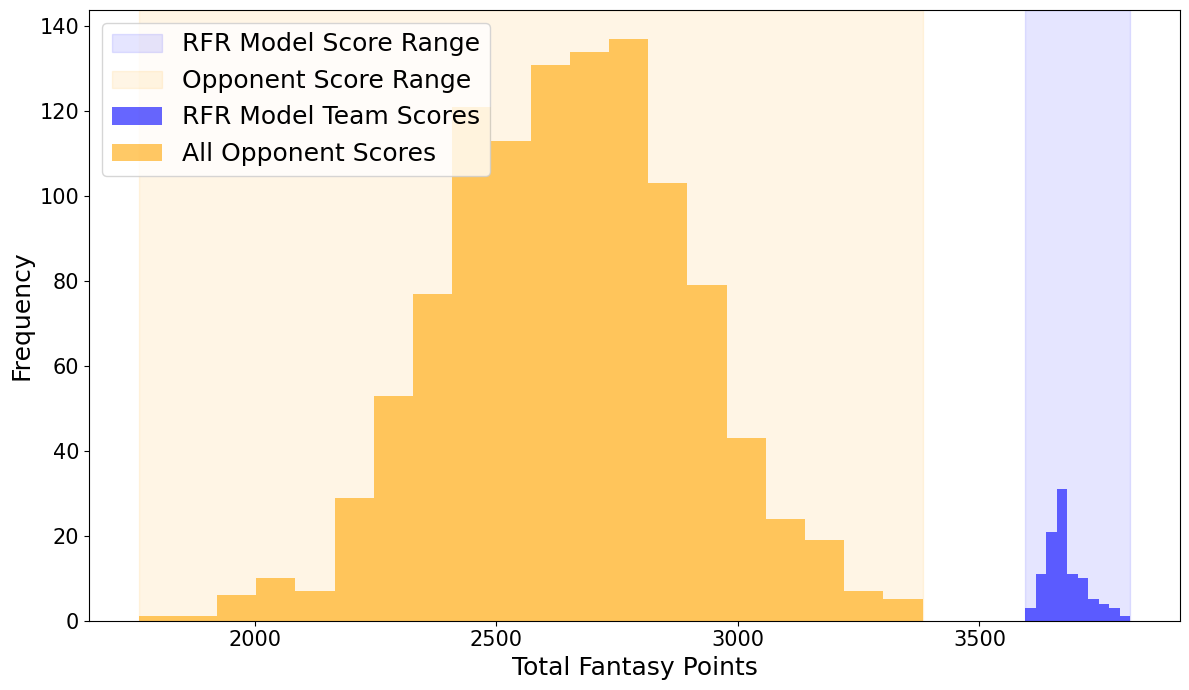

In [18]:
plot_model_vs_all_opponents_histogram(
    rfr_results["model_scores"],
    rfr_results["all_opponent_scores"],
    model_name="RFR Model"
)

In [19]:
def compute_score_distribution_gap(model_scores, all_opp_scores):
    """
    Computes the gap between the lower bound of the model score distribution 
    and the upper bound of the opponent score distribution.

    Gap = min(model_scores) - max(opponent_scores)

    A positive gap means the two distributions DO NOT overlap.
    A negative gap means they DO overlap.
    """

    # Flatten opponent scores
    flattened_opp_scores = [s for sim in all_opp_scores for s in sim]

    # Compute bounds
    model_low = min(model_scores)
    opp_high = max(flattened_opp_scores)

    # Compute the gap
    gap = model_low - opp_high

    print("Lowest model score:      ", model_low)
    print("Highest opponent score:  ", opp_high)
    print("Score distribution gap:  ", gap)

    return gap

gap_value = compute_score_distribution_gap(rfr_results["model_scores"], rfr_results["all_opponent_scores"])
print("Final gap:", gap_value)

Lowest model score:       3594.6000000000004
Highest opponent score:   3382.4
Score distribution gap:   212.20000000000027
Final gap: 212.20000000000027
